In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.signal as signal
import torch.distributions as dist
from jaxtyping import Float, Int
from torch import Tensor
import spikeinterface.extractors as se
import spikeinterface.comparison as sc
from spikeinterface.preprocessing import bandpass_filter
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from scipy.signal import find_peaks
import h5py

In [2]:
def load_mearec_data(recording_file="recordings.h5"):
    """
    Load MEArec data and convert to PyTorch tensors compatible with the notebook format
    """
    # Load MEArec data
    recording, sorting_true = se.read_mearec(recording_file)
    
    # Apply preprocessing (bandpass filter)
    recording_filt = bandpass_filter(recording, freq_min=300, freq_max=6000)
    
    # Get traces as numpy array and convert to torch tensor
    traces = torch.tensor(recording_filt.get_traces(), dtype=torch.float32)
    
    # Get ground truth spike times and IDs
    true_spike_times = []
    true_spike_ids = []
    
    for unit_id in sorting_true.unit_ids:
        unit_spikes = sorting_true.get_unit_spike_train(unit_id)
        true_spike_times.extend(unit_spikes)
        # Convert unit_id to integer (remove '#' if present)
        unit_idx = int(unit_id.lstrip('#')) if isinstance(unit_id, str) else int(unit_id)
        true_spike_ids.extend([unit_idx] * len(unit_spikes))
    
    # Sort by spike times
    sorted_indices = np.argsort(true_spike_times)
    true_spike_times = torch.tensor([true_spike_times[i] for i in sorted_indices], dtype=torch.long)
    true_spike_ids = torch.tensor([true_spike_ids[i] for i in sorted_indices], dtype=torch.long)
    
    # Extract true templates from MEArec data
    with h5py.File(recording_file, 'r') as f:
        templates = f['templates'][:]  # Shape: (n_units, n_jitters, n_channels, n_samples)
        
    # Convert templates to the expected format: (n_units, n_samples, n_channels)
    # Take median across jitters and transpose
    true_templates = torch.tensor(np.median(templates, axis=1).transpose(0, 2, 1), dtype=torch.float32)
    
    # Constants
    sampling_frequency = recording.sampling_frequency
    num_samples, num_channels = traces.shape
    true_num_spikes = len(true_spike_times)
    true_num_neurons, window_size, _ = true_templates.shape
    
    return {
        'traces': traces,
        'true_spike_times': true_spike_times,
        'true_spike_ids': true_spike_ids,
        'true_templates': true_templates,
        'sampling_frequency': sampling_frequency,
        'num_samples': num_samples,
        'num_channels': num_channels,
        'true_num_spikes': true_num_spikes,
        'true_num_neurons': true_num_neurons,
        'window_size': window_size
    }

In [3]:
data = load_mearec_data("data/sim_data/recordings5.h5")

# Extract variables in the same format as the original notebook
traces = data['traces']
true_spike_times = data['true_spike_times']
true_spike_ids = data['true_spike_ids']
true_templates = data['true_templates']

SAMPLING_FREQUENCY = data['sampling_frequency']
NUM_SAMPLES, NUM_CHANNELS = traces.shape
TRUE_NUM_SPIKES = data['true_num_spikes']
TRUE_NUM_NEURONS, WINDOW_SIZE, _ = true_templates.shape
WINDOW_SIZE = 96

print(f"✅ Loaded MEArec data:")
print(f"   Traces shape: {traces.shape}")
print(f"   True spikes: {TRUE_NUM_SPIKES}")
print(f"   True neurons: {TRUE_NUM_NEURONS}")
print(f"   Sampling frequency: {SAMPLING_FREQUENCY} Hz")
print(f"   Window size: {WINDOW_SIZE}")

✅ Loaded MEArec data:
   Traces shape: torch.Size([640000, 4])
   True spikes: 669
   True neurons: 4
   Sampling frequency: 32000.0 Hz
   Window size: 96


In [4]:
def plot_slice(traces: Float[Tensor, "num_samples num_channels"],
               spike_times: Int[Tensor, "num_spikes"],
               spike_ids: Int[Tensor, "num_spikes"],
               start_time: float=0,
               end_time: float=1.0,
               ylim: float=None):
    """
    Plot a slice of the recording and the corresponding spike times.
    """
    # Extract constants
    num_samples, num_channels = traces.shape
    num_neurons = spike_ids.max() + 1
    
    # Extract the slice of the recording
    slc = slice(int(start_time * SAMPLING_FREQUENCY), int(end_time * SAMPLING_FREQUENCY))
    
    # Get the y-limit for traces if not specified
    if ylim is None:
        ylim = 1.05 * traces[slc].abs().max()
    
    # Make an array of times in seconds
    times_sec = torch.arange(0, num_samples) / SAMPLING_FREQUENCY
    spike_times_sec = times_sec[spike_times]
    spike_in_slice = (spike_times_sec >= start_time) & (spike_times_sec <= end_time)
    
    # Plot the spike raster
    fig, axs = plt.subplots(num_channels + 1, 1, sharex=True, figsize=(6, 1.5 * (num_channels + 1)))
    
    axs[0].plot(spike_times_sec[spike_in_slice], spike_ids[spike_in_slice], '|k', markersize=6)
    axs[0].set_ylabel("neuron")
    axs[0].set_yticks(torch.arange(0, num_neurons))
    axs[0].set_title("spike train")
    
    # Plot the voltage traces
    for i in range(num_channels):
        axs[i+1].plot(times_sec[slc], traces[slc, i], color='k', lw=1, alpha=0.5)
        axs[i+1].set_title(f"channel {i+1}", fontsize=10)
        axs[i+1].set_ylim(-ylim, ylim)
        axs[i+1].set_ylabel("trace\n[z-score]")
        axs[i+1].set_xlim(start_time, end_time)
        if i == num_channels - 1:
            axs[i+1].set_xlabel(f"time [sec]")
    
    plt.tight_layout()
    return fig, axs

In [5]:
def plot_waveforms(waveforms: Float[Tensor, "num_waveforms windows_size num_channels"],
                   name: str="waveform"):
    """
    Plot a grid of spike waveforms or templates.
    """
    num_waveforms, window_size, num_channels = waveforms.shape
    times = torch.arange(-window_size//2, window_size//2) / SAMPLING_FREQUENCY * 1000
    
    fig, axs = plt.subplots(num_channels, num_waveforms,
                           figsize=(1.25 * num_waveforms, 1.25 * num_channels),
                           sharex=True, sharey=True)
    
    # Handle case where there's only one channel or one waveform
    if num_channels == 1:
        axs = axs.reshape(1, -1)
    if num_waveforms == 1:
        axs = axs.reshape(-1, 1)
    
    lim = 1.05 * waveforms.abs().max()
    
    for j in range(num_waveforms):
        for i in range(num_channels):
            axs[i,j].plot(times, waveforms[j,:,i], color='k', lw=1, alpha=0.5)
            axs[i,j].set_ylim(-lim, lim)
            
            if j == 0:
                axs[i,j].set_ylabel(f"channel {i}\n [z-score]")
            if i == 0:
                axs[i,j].set_title(f"{name} {j}")
            if i == num_channels - 1:
                axs[i,j].set_xlabel(f"time [ms]")
    
    plt.tight_layout()
    return fig, axs

In [6]:
def evaluate_detected_spikes(
    detected_spike_times: Int[Tensor, "num_detected_spikes"],
    true_spike_times: Int[Tensor, "num_true_spikes"]) -> dict:
    """
    Evaluate detected spikes against ground truth with boundary handling
    """
    num_windows = NUM_SAMPLES // WINDOW_SIZE
    
    # Filter out spikes that would cause out-of-bounds errors
    # Keep only spikes that fall within valid window boundaries
    valid_true_spikes = true_spike_times[true_spike_times < num_windows * WINDOW_SIZE]
    valid_detected_spikes = detected_spike_times[detected_spike_times < num_windows * WINDOW_SIZE]
    
    # Create masks for windows containing spikes
    true_spike_mask = torch.zeros(num_windows, dtype=torch.bool)
    if len(valid_true_spikes) > 0:
        true_spike_mask[valid_true_spikes // WINDOW_SIZE] = True
    
    detected_spike_mask = torch.zeros(num_windows, dtype=torch.bool)
    if len(valid_detected_spikes) > 0:
        detected_spike_mask[valid_detected_spikes // WINDOW_SIZE] = True
    
    # Calculate confusion matrix elements
    tp = (true_spike_mask & detected_spike_mask).sum().item()
    fp = (detected_spike_mask & ~true_spike_mask).sum().item()
    fn = (~detected_spike_mask & true_spike_mask).sum().item()
    tn = (~detected_spike_mask & ~true_spike_mask).sum().item()
    
    return dict(tp=tp, fp=fp, fn=fn, tn=tn)

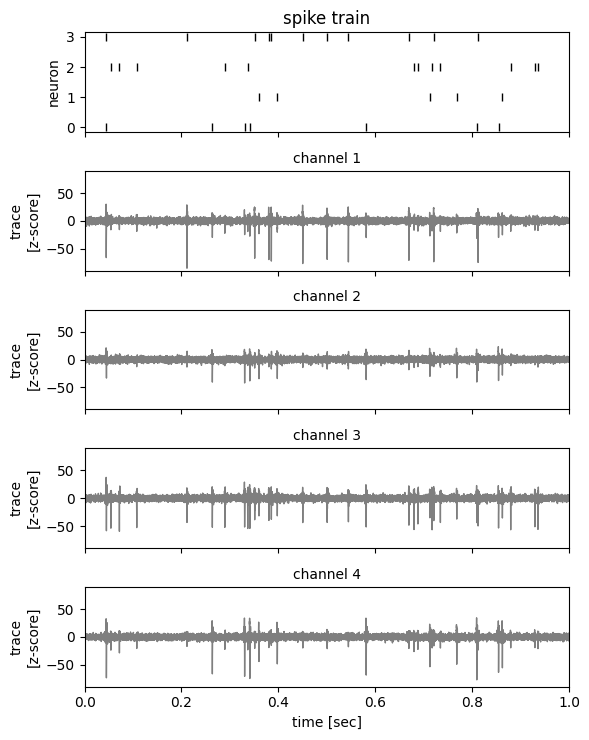

In [7]:
# Plot the first second of MEArec data
_ = plot_slice(traces, true_spike_times, true_spike_ids, start_time=0.0, end_time=1.0)

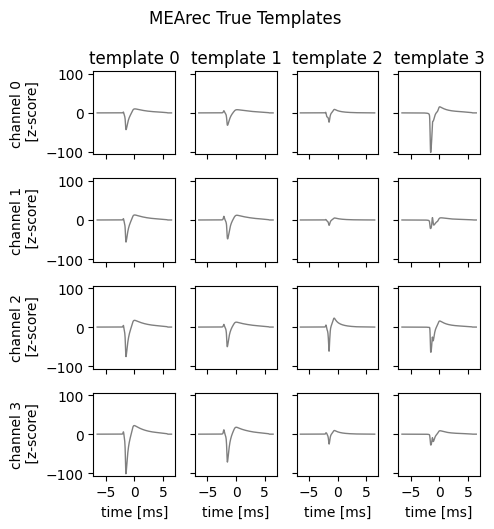

In [8]:
# Plot true templates
fig, axs = plot_waveforms(true_templates, name="template")
fig.suptitle("MEArec True Templates", y=1.05)
plt.show()

In [9]:
import spikeinterface.sorters as ss
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

# Use SpikeInterface's peak detection
print("🔧 Using SpikeInterface peak detection...")

# Convert back to SpikeInterface format temporarily
recording_si = se.read_mearec("data/sim_data/recordings5.h5")[0]
recording_filt = bandpass_filter(recording_si, freq_min=300, freq_max=6000)

# Detect peaks using SpikeInterface
peaks = detect_peaks(recording_filt, 
                    method='locally_exclusive',
                    peak_sign='neg',
                    detect_threshold=5.0,
                    exclude_sweep_ms=1.0)

# Convert back to torch tensors
si_spike_times = torch.tensor(peaks['sample_index'])
print(f"✅ SpikeInterface detected {len(si_spike_times)} spikes")

# Extract waveforms using SpikeInterface detection
#spike_waveforms_si = torch.zeros((len(si_spike_times), WINDOW_SIZE, NUM_CHANNELS))
traces_np = recording_filt.get_traces()

# for i, t in enumerate(si_spike_times):
#     start_idx = t - WINDOW_SIZE // 2
#     end_idx = t + WINDOW_SIZE // 2
    
#     if start_idx >= 0 and end_idx < traces_np.shape[0]:
#         spike_waveforms_si[i] = torch.tensor(traces_np[start_idx:end_idx])





🔧 Using SpikeInterface peak detection...


noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

detect peaks using locally_exclusive (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

✅ SpikeInterface detected 654 spikes


Extracting waveforms with window size 96...
✅ Extracted 654 valid waveforms


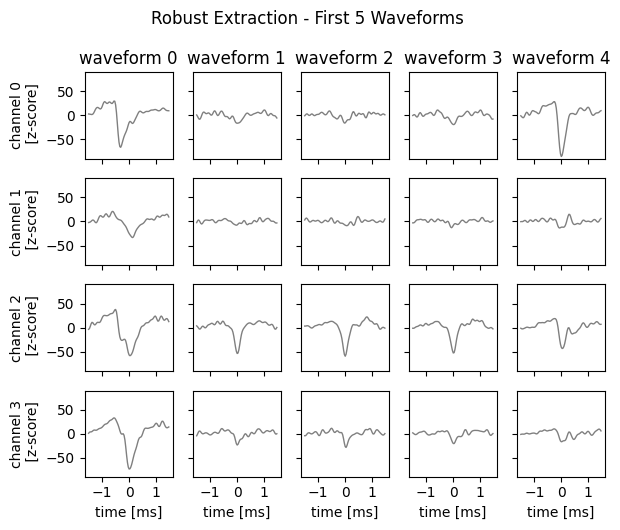

In [10]:
def extract_waveforms_robust(traces_np, spike_times, window_size):
    """
    Robust waveform extraction with proper boundary handling
    """
    num_spikes = len(spike_times)
    num_samples, num_channels = traces_np.shape
    half_window = window_size // 2
    
    spike_waveforms = []
    valid_spike_times = []
    
    print(f"Extracting waveforms with window size {window_size}...")
    
    for i, t in enumerate(spike_times):
        start_idx = int(t - half_window)
        end_idx = int(t + half_window)
        
        # Check boundaries
        if start_idx >= 0 and end_idx < num_samples:
            waveform = traces_np[start_idx:end_idx, :]
            
            # Verify we got the right shape
            if waveform.shape[0] == window_size:
                spike_waveforms.append(torch.tensor(waveform))
                valid_spike_times.append(t)
            else:
                print(f"Skipping spike {i}: wrong shape {waveform.shape}")
        else:
            print(f"Skipping spike {i}: out of bounds (start={start_idx}, end={end_idx})")
    
    if len(spike_waveforms) > 0:
        spike_waveforms = torch.stack(spike_waveforms)
        print(f"✅ Extracted {len(spike_waveforms)} valid waveforms")
    else:
        print("❌ No valid waveforms extracted!")
        spike_waveforms = torch.zeros((0, window_size, num_channels))
    
    return spike_waveforms, torch.tensor(valid_spike_times)


# Apply robust extraction
spike_waveforms_fixed, valid_spike_times = extract_waveforms_robust(
    traces_np, si_spike_times, WINDOW_SIZE
)

# Plot the results
if len(spike_waveforms_fixed) > 0:
    fig, axs = plot_waveforms(spike_waveforms_fixed[:5], name="waveform")
    fig.suptitle("Robust Extraction - First 5 Waveforms", y=1.05)
    plt.show()
else:
    print("No waveforms to plot!")

In [ ]:
import numpy as np
from fastdtw import fastdtw
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import multiprocessing
from joblib import Parallel, delayed

class DTWAffinitySpikeSorter:
    """
    DTW-based spike clustering using Affinity Propagation
    Based on PMC5842698: "Clustering of Interictal Spikes by Dynamic Time Warping and Affinity Propagation"
    """
    
    def __init__(self, damping=0.5, max_iter=200, convergence_iter=15, n_jobs=None):
        self.damping = damping
        self.max_iter = max_iter
        self.convergence_iter = convergence_iter
        self.n_jobs = n_jobs or multiprocessing.cpu_count()  # Use all available cores
        self.affinity_matrix = None
        self.cluster_centers_indices = None
        self.labels = None
        self.templates = None
        
    def _compute_dtw_similarity_matrix(self, spike_waveforms):
        """
        Compute DTW similarity matrix for all spike pairs using parallel processing
        From paper: "DTW is a robust method for calculating similarity between temporal sequences"
        """
        n_spikes = len(spike_waveforms)
        
        print(f"Computing DTW similarity matrix for {n_spikes} spikes using {self.n_jobs} cores...")
        
        def compute_dtw_row(i):
            """Compute DTW similarities for one spike against all others"""
            row = np.zeros(n_spikes)
            wave1 = spike_waveforms[i].flatten()
            wave1 = (wave1 - np.mean(wave1)) / (np.std(wave1) + 1e-8)
            
            for j in range(n_spikes):
                if i == j:
                    row[j] = 0.0  # Self-similarity
                else:
                    wave2 = spike_waveforms[j].flatten()
                    wave2 = (wave2 - np.mean(wave2)) / (np.std(wave2) + 1e-8)
                    
                    # Compute DTW distance
                    dtw_distance, _ = fastdtw(wave1, wave2, dist=lambda x, y: (x - y) ** 2)
                    
                    # Convert distance to similarity (negative distance as in paper)
                    row[j] = -dtw_distance
            return row
        
        # Parallel computation using all available cores
        similarity_rows = Parallel(n_jobs=self.n_jobs, backend='threading')(
            delayed(compute_dtw_row)(i) for i in tqdm(range(n_spikes), desc="DTW similarity matrix")
        )
        
        return np.array(similarity_rows)
    
    def fit(self, spike_waveforms):
        """
        Fit DTW-Affinity Propagation clustering to spike waveforms
        Args:
            spike_waveforms: numpy array of shape (n_spikes, window_size, n_channels)
        """
        print("DTW-Affinity Propagation Spike Clustering")
        print("=" * 50)
        
        # Convert PyTorch tensor to numpy if needed
        if torch.is_tensor(spike_waveforms):
            spike_waveforms = spike_waveforms.cpu().numpy()
        
        n_spikes, window_size, n_channels = spike_waveforms.shape
        print(f"Processing {n_spikes} spikes ({window_size} samples x {n_channels} channels)")
        
        # Step 1: Compute DTW similarity matrix (now parallelized)
        self.affinity_matrix = self._compute_dtw_similarity_matrix(spike_waveforms)
        
        # Step 2: Set preference (median of similarities as in paper)
        preference = np.median(self.affinity_matrix)
        print(f"Setting preference to median similarity: {preference:.3f}")
        
        # Step 3: Apply Affinity Propagation clustering
        print("Applying Affinity Propagation clustering...")
        af = AffinityPropagation(
            affinity='precomputed',
            damping=self.damping,
            max_iter=self.max_iter,
            convergence_iter=self.convergence_iter,
            preference=preference,
            random_state=42
        )
        
        af.fit(self.affinity_matrix)
        
        # Extract results
        self.cluster_centers_indices = af.cluster_centers_indices_
        self.labels = af.labels_
        n_clusters = len(self.cluster_centers_indices)
        
        print(f"Clustering complete!")
        print(f"Number of clusters found: {n_clusters}")
        print(f"Cluster centers (exemplar indices): {self.cluster_centers_indices}")
        
        # Step 4: Generate templates from clusters
        self.templates = self._generate_templates(spike_waveforms)
        
        return self
    
    def _generate_templates(self, spike_waveforms):
        """
        Generate templates as mean of each cluster
        From paper: "exemplars are representative data points of each cluster"
        """
        n_clusters = len(self.cluster_centers_indices)
        window_size, n_channels = spike_waveforms.shape[1], spike_waveforms.shape[2]
        templates = np.zeros((n_clusters, window_size, n_channels))
        
        print("Generating cluster templates...")
        for cluster_id in range(n_clusters):
            cluster_mask = (self.labels == cluster_id)
            cluster_spikes = spike_waveforms[cluster_mask]
            
            if len(cluster_spikes) > 0:
                # Use mean as template (could also use median)
                templates[cluster_id] = np.mean(cluster_spikes, axis=0)
                print(f"Cluster {cluster_id}: {np.sum(cluster_mask)} spikes")
        
        return templates

def run_dtw_affinity_spike_sorting(spike_waveforms, true_labels=None, true_num_neurons=None):
    """
    Complete DTW-Affinity Propagation spike sorting pipeline
    """
    print("\nDTW-AFFINITY PROPAGATION SPIKE SORTING PIPELINE")
    print("=" * 60)
    print("Based on PMC5842698: DTW + Affinity Propagation for spike clustering")
    print()
    
    # Initialize and fit the sorter with parallelization
    max_cores = multiprocessing.cpu_count()
    print(f"Using {max_cores} CPU cores for parallel DTW computation")
    
    sorter = DTWAffinitySpikeSorter(
        damping=0.5, 
        max_iter=200, 
        convergence_iter=15,
        n_jobs=max_cores  # Use all available cores
    )
    sorter.fit(spike_waveforms)
    
    # Extract results
    cluster_labels = sorter.labels
    templates = sorter.templates
    n_clusters = len(sorter.cluster_centers_indices)
    
    # Convert to torch tensors for compatibility with plotting functions
    templates_torch = torch.tensor(templates, dtype=torch.float32)
    cluster_labels_torch = torch.tensor(cluster_labels, dtype=torch.long)
    
    results = {
        'cluster_labels': cluster_labels_torch,
        'templates': templates_torch,
        'n_clusters': n_clusters,
        'cluster_centers_indices': sorter.cluster_centers_indices,
        'affinity_matrix': sorter.affinity_matrix,
        'sorter': sorter
    }
    
    return results

# Integration with your existing notebook
def evaluate_dtw_affinity_clustering(dtw_results, true_spike_ids, spike_waveforms):
    """
    Evaluate DTW-Affinity clustering results against ground truth
    """
    cluster_labels = dtw_results['cluster_labels'].numpy()
    n_clusters = dtw_results['n_clusters']
    
    # Create confusion matrix
    cm = confusion_matrix(true_spike_ids.numpy(), cluster_labels)
    
    # Calculate Adjusted Rand Index
    ari = adjusted_rand_score(true_spike_ids.numpy(), cluster_labels)
    
    return cm, ari

# Main execution pipeline
print("Running DTW-Affinity Propagation Spike Sorting...")

# Use your extracted spike waveforms
dtw_affinity_results = run_dtw_affinity_spike_sorting(
    spike_waveforms_fixed,
    true_labels=true_spike_ids,
    true_num_neurons=TRUE_NUM_NEURONS
)

# Extract results
dtw_cluster_labels = dtw_affinity_results['cluster_labels']
dtw_templates = dtw_affinity_results['templates']
dtw_n_clusters = dtw_affinity_results['n_clusters']

print(f"\nDTW-Affinity Results:")
print(f"Clusters found: {dtw_n_clusters}")
print(f"Template shape: {dtw_templates.shape}")

# Plot generated templates
fig, axs = plot_waveforms(dtw_templates, name="DTW-AP template")
fig.suptitle("DTW-Affinity Propagation Generated Templates", y=1.05)
plt.show()

# Evaluate against ground truth using existing spike times
def create_confusion_matrix_with_ground_truth():
    """
    Create confusion matrix by matching detected spikes to ground truth
    """
    # Use ground truth spike times for cleaner evaluation
    gt_waveforms = []
    valid_gt_ids = []
    
    for i, t in enumerate(true_spike_times[:len(dtw_cluster_labels)]):
        start_idx = t - WINDOW_SIZE // 2
        end_idx = t + WINDOW_SIZE // 2
        if start_idx >= 0 and end_idx < traces.shape[0]:
            gt_waveforms.append(traces[start_idx:end_idx])
            valid_gt_ids.append(true_spike_ids[i])
    
    valid_gt_ids = torch.tensor(valid_gt_ids[:len(dtw_cluster_labels)])
    
    # Create confusion matrix
    cm = confusion_matrix(valid_gt_ids.numpy(), dtw_cluster_labels.numpy())
    ari = adjusted_rand_score(valid_gt_ids.numpy(), dtw_cluster_labels.numpy())
    
    return cm, ari, valid_gt_ids

# Generate confusion matrix
cm_dtw, ari_dtw, matched_gt_ids = create_confusion_matrix_with_ground_truth()

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm_dtw, interpolation="none", cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('DTW-Affinity Cluster IDs')
plt.ylabel('True Neuron IDs')
plt.title("DTW-Affinity Propagation: Confusion Matrix")

# Add text annotations
for i in range(cm_dtw.shape[0]):
    for j in range(cm_dtw.shape[1]):
        plt.text(j, i, str(cm_dtw[i, j]), ha='center', va='center',
                color='white' if cm_dtw[i, j] > cm_dtw.max() / 2 else 'black')

plt.tight_layout()
plt.show()

# Print performance metrics
print(f"\nDTW-Affinity Propagation Performance:")
print(f"Adjusted Rand Index: {ari_dtw:.3f}")
print(f"Number of clusters: {dtw_n_clusters}")
print(f"Confusion Matrix Shape: {cm_dtw.shape}")

# Compare with your existing GMM results
print(f"\nComparison with GMM:")
print(f"GMM ARI: {ari_gt:.3f}")
print(f"DTW-Affinity ARI: {ari_dtw:.3f}")
print(f"Improvement: {((ari_dtw - ari_gt) / ari_gt * 100):.1f}%")


Running DTW-Affinity Propagation Spike Sorting...

DTW-AFFINITY PROPAGATION SPIKE SORTING PIPELINE
Based on PMC5842698: DTW + Affinity Propagation for spike clustering

Using 10 CPU cores for parallel DTW computation
DTW-Affinity Propagation Spike Clustering
Processing 654 spikes (96 samples x 4 channels)
Computing DTW similarity matrix for 654 spikes using 10 cores...


DTW similarity matrix:   0%|          | 0/654 [00:00<?, ?it/s]